<a href="https://colab.research.google.com/github/oxypilus/Convolution-Neural-Network-for-Topic-Classification/blob/main/Convolution_NN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataset import random_split
from tqdm import tqdm, tqdm_notebook

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
categories = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball']
twenty_train = fetch_20newsgroups(categories=categories, shuffle=True, random_state=42)

In [4]:
data = {"news": twenty_train.data, "labels": twenty_train.target}

In [5]:
class Sequences(Dataset):
    def __init__(self):
        max_seq_len = 124
        df = pd.DataFrame(data)
        vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.005)
        vectorizer.fit(df.news.tolist())

        onehotencoder = OneHotEncoder()
        targets = np.array(df.labels.tolist())
        targets = onehotencoder.fit_transform(targets.reshape(-1,1))

        tokenizer = vectorizer.build_analyzer()
        token2idx = vectorizer.vocabulary_
        token2idx["<PAD>"] = len(token2idx)
        self.encode = lambda x: [token2idx[token] for token in tokenizer(x) if token in token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [token2idx["<PAD>"]]

        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df.news.tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label in zip(sequences, targets.toarray()) if sequences])
        self.sequences = [self.pad(sequence) for sequence in sequences]

        self.sequences = torch.LongTensor(self.sequences)#.toarray())
        self.labels = torch.FloatTensor(targets.toarray())
        self.token2idx = vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

    def __getitem__(self, i):
        return self.sequences[i, :], self.labels[i]

    def __len__(self):
        return self.sequences.shape[0]

In [6]:
dataset = Sequences()

In [7]:
def split_train_valid_test(corpus, valid_ratio = 0.1, test_ratio = 0.1):
  test_length = int(len(corpus) * test_ratio)
  valid_length = int(len(corpus) * valid_ratio)
  train_length = len(corpus) - valid_length - test_length
  return random_split (corpus, lengths = [train_length, valid_length, test_length])

In [8]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test (dataset)
len(train_dataset), len(valid_dataset), len(test_dataset)

(4632, 579, 579)

In [9]:
BATCH_SIZE = 500

train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset,batch_size = BATCH_SIZE)
valid_loader = DataLoader(valid_dataset,batch_size = BATCH_SIZE)

In [10]:
class Conv_model(nn.Module):
  def __init__ (self, inp_size, hidden1, hidden2):
    super(Conv_model, self).__init__()

    self.filter_sizes = [3, 4, 5, 6]
    self.num_filters = [15, 15, 15, 15]
    self.dropout = nn.Dropout(p=0.5)

    self.embed = nn.Embedding(len(dataset.token2idx), 300, len(dataset.token2idx) - 1)
    self.conv1d_list = nn.ModuleList([nn.Conv1d(in_channels = 300, out_channels = self.num_filters[i], kernel_size = self.filter_sizes[i]) for i in range(len(self.filter_sizes))])
    self.fc1 = nn.Linear(60,30)#(inp_size,hidden1)
    self.fc2 = nn.Linear(30,10)#(hidden1, hidden2)

  def forward (self, inp):
    x = self.embed(inp)
    x_reshaped = x.permute(0,2,1)
    x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]
    x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
    out = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
    out = F.relu(self.fc1(out))
    out = self.fc2(out)

    return out

In [11]:
model = Conv_model(40, 20 , 10)
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [13]:
train_losses, valid_losses = [], []
for epoch in range(25):
  model.train()
  total_loss, total = 0,0
  for inputs, target in train_loader:
    inputs = inputs.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(inputs)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    scheduler.step()
    total_loss += loss.item()
    total += 1
  train_loss = total_loss/total

  if epoch % 1 == 0:
    model.eval()
    total_loss, total = 0,0
    with torch.no_grad():
      for inputs, target in valid_loader:
        inputs = inputs.to(device)
        target = target.to(device)
        output = model(inputs)
        loss = criterion(output, target)
        total_loss += loss.item()
        total += 1
    valid_loss = total_loss/total

    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
      print("Stopping early")
      break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(
        f'epoch #{epoch + 1:3d}\ttrain_loss: {train_loss:.3f}\tvalid_loss: {valid_loss:.3f}\n',
    )

epoch #  1	train_loss: 2.313	valid_loss: 2.280

epoch #  2	train_loss: 2.217	valid_loss: 2.208

epoch #  3	train_loss: 2.060	valid_loss: 2.102

epoch #  4	train_loss: 1.967	valid_loss: 1.986

epoch #  5	train_loss: 1.718	valid_loss: 1.823

epoch #  6	train_loss: 1.589	valid_loss: 1.666

epoch #  7	train_loss: 1.299	valid_loss: 1.482

epoch #  8	train_loss: 1.176	valid_loss: 1.358

epoch #  9	train_loss: 0.948	valid_loss: 1.223

epoch # 10	train_loss: 0.854	valid_loss: 1.147

epoch # 11	train_loss: 0.686	valid_loss: 1.046

epoch # 12	train_loss: 0.610	valid_loss: 0.996

epoch # 13	train_loss: 0.486	valid_loss: 0.914

epoch # 14	train_loss: 0.427	valid_loss: 0.886

epoch # 15	train_loss: 0.340	valid_loss: 0.821

epoch # 16	train_loss: 0.296	valid_loss: 0.810

epoch # 17	train_loss: 0.237	valid_loss: 0.760

epoch # 18	train_loss: 0.205	valid_loss: 0.761

epoch # 19	train_loss: 0.165	valid_loss: 0.721

epoch # 20	train_loss: 0.144	valid_loss: 0.725

epoch # 21	train_loss: 0.116	valid_loss:

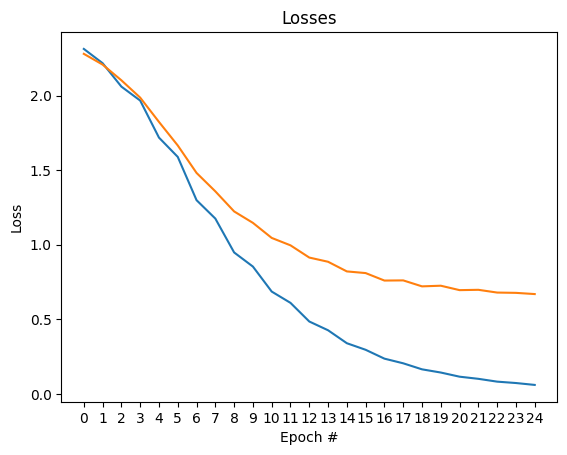

In [14]:
epoch_ticks = range(epoch+1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.title("Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.xticks(epoch_ticks)
plt.show()

In [15]:
model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for inputs, target in test_loader:
        inputs = inputs.to(device)
        target = target.to(device)

        probs = model(inputs)
        probs = probs.detach().cpu().numpy()
        predict = np.argmax (probs, axis=1)
        target = target.cpu().numpy()
        target = np.argmax (target, axis = 1)

        y_true.extend(predict)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        39
           1       0.69      0.76      0.72        58
           2       0.79      0.79      0.79        72
           3       0.64      0.78      0.70        59
           4       0.82      0.71      0.76        66
           5       0.82      0.78      0.80        54
           6       0.80      0.77      0.79        57
           7       0.84      0.79      0.81        58
           8       0.87      0.91      0.89        57
           9       0.88      0.76      0.82        59

    accuracy                           0.80       579
   macro avg       0.81      0.81      0.80       579
weighted avg       0.80      0.80      0.80       579



In [16]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
      inputs = torch.LongTensor(dataset.pad(dataset.encode(text)[:124])).to(device)
      inputs = torch.reshape(inputs, (1,124))
      probs = model(inputs)
      probs = probs.detach().cpu().numpy()
      predict = np.argmax (probs, axis=1)[0]

      categories = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball']

      answer = categories[predict]

      return answer



In [17]:
df = pd.DataFrame(data)

In [18]:
predict_sentiment(df.news[3])

'alt.atheism'